# SpaceX Data Collection & Analysis

## 1. Setup: Imports and configuration

All imports are in one place. Install any missing packages before running (e.g., `!pip install requests` in Colab).

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import json

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
plt.rcParams['figure.figsize'] = (10,5)


## 2. Helper functions
Small utility functions for API requests and datetime conversion.

In [2]:
def fetch_json(url, params=None, timeout=10):
    """Fetch JSON from URL with basic error handling."""
    try:
        resp = requests.get(url, params=params, timeout=timeout)
        resp.raise_for_status()
        return resp.json()
    except requests.RequestException as e:
        raise RuntimeError(f"API request failed: {e}") from e

def to_datetime(ts):
    """Convert ISO timestamp to pandas datetime (handles None)."""
    if pd.isna(ts) or ts is None:
        return pd.NaT
    try:
        return pd.to_datetime(ts)
    except Exception:
        # fallback: try parsing with datetime
        try:
            return pd.to_datetime(datetime.fromisoformat(ts.rstrip('Z')))
        except Exception:
            return pd.NaT


## 3. Fetch SpaceX launches data
Using the official SpaceX REST API (v4). This section fetches the launches endpoint and converts to a DataFrame.

In [3]:
API_LAUNCHES = 'https://api.spacexdata.com/v4/launches'

raw = fetch_json(API_LAUNCHES)
print(f"Fetched {len(raw)} launches")

# Build DataFrame with selected fields
records = []
for item in raw:
    rec = {
        'id': item.get('id'),
        'name': item.get('name'),
        'date_utc': item.get('date_utc'),
        'date_local': item.get('date_local'),
        'success': item.get('success'),
        'flight_number': item.get('flight_number'),
        'rocket': item.get('rocket'),
        'launchpad': item.get('launchpad'),
        'details': item.get('details'),
        'payloads': item.get('payloads'),
        'cores': item.get('cores')
    }
    records.append(rec)

df = pd.DataFrame.from_records(records)
df['date_utc'] = df['date_utc'].apply(to_datetime)
df['year'] = df['date_utc'].dt.year
df['month'] = df['date_utc'].dt.month
df['day'] = df['date_utc'].dt.day

print('DataFrame shape:', df.shape)
df.head()


Fetched 205 launches
DataFrame shape: (205, 14)


,id,name,date_utc,date_local,success,flight_number,rocket,launchpad,details,payloads,cores,year,month,day
0,5eb87cd9ffd86e000604b32a,FalconSat,2006-03-24 22:30:00+00:00,2006-03-25T10:30:00+12:00,False,1,5e9d0d95eda69955f709d1eb,5e9e4502f5090995de566f86,Engine failure at 33 seconds and loss of vehicle,[5eb0e4b5b6c3bb0006eeb1e1],"[{'core': '5e9e289df35918033d3b2623', 'flight'...",2006,3,24
1,5eb87cdaffd86e000604b32b,DemoSat,2007-03-21 01:10:00+00:00,2007-03-21T13:10:00+12:00,False,2,5e9d0d95eda69955f709d1eb,5e9e4502f5090995de566f86,Successful first stage burn and transition to ...,[5eb0e4b6b6c3bb0006eeb1e2],"[{'core': '5e9e289ef35918416a3b2624', 'flight'...",2007,3,21
2,5eb87cdbffd86e000604b32c,Trailblazer,2008-08-03 03:34:00+00:00,2008-08-03T15:34:00+12:00,False,3,5e9d0d95eda69955f709d1eb,5e9e4502f5090995de566f86,Residual stage 1 thrust led to collision betwe...,"[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006e...","[{'core': '5e9e289ef3591814873b2625', 'flight'...",2008,8,3
3,5eb87cdbffd86e000604b32d,RatSat,2008-09-28 23:15:00+00:00,2008-09-28T11:15:00+12:00,True,4,5e9d0d95eda69955f709d1eb,5e9e4502f5090995de566f86,Ratsat was carried to orbit on the first succe...,[5eb0e4b7b6c3bb0006eeb1e5],"[{'core': '5e9e289ef3591855dc3b2626', 'flight'...",2008,9,28
4,5eb87cdcffd86e000604b32e,RazakSat,2009-07-13 03:35:00+00:00,2009-07-13T15:35:00+12:00,True,5,5e9d0d95eda69955f709d1eb,5e9e4502f5090995de566f86,None,[5eb0e4b7b6c3bb0006eeb1e6],"[{'core': '5e9e289ef359184f103b2627', 'flight'...",2009,7,13


## 4. Basic cleaning & exploration
- Check missing values
- Basic counts: success vs failure
- Launches per year

In [4]:
# Missing values summary
missing = df.isna().sum().sort_values(ascending=False)
missing.head(10)


,0
details,71
success,19
name,0
date_utc,0
date_local,0
id,0
flight_number,0
rocket,0
launchpad,0
payloads,0


In [5]:
# Success vs Failure counts (where success is not None)
success_counts = df['success'].value_counts(dropna=True)
print(success_counts)


success
True     181
False      5
Name: count, dtype: int64


In [6]:
# Launches per year
launches_per_year = df.groupby('year').size().rename('launch_count').reset_index()
launches_per_year


,year,launch_count
0,2006,1
1,2007,1
2,2008,2
3,2009,1
4,2010,2
5,2012,2
6,2013,3
7,2014,6
8,2015,7
9,2016,9


## 5. Visualizations
A couple of clear plots to show trends and success rate.

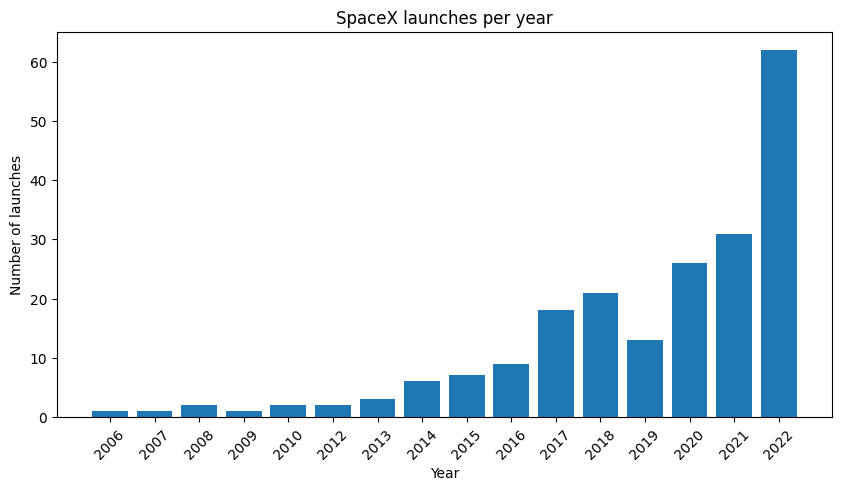

In [7]:
# Launches per year bar chart
if not launches_per_year.empty:
    fig, ax = plt.subplots()
    ax.bar(launches_per_year['year'].astype(str), launches_per_year['launch_count'])
    ax.set_title('SpaceX launches per year')
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of launches')
    plt.xticks(rotation=45)
    plt.show()
else:
    print('No launch data to plot')


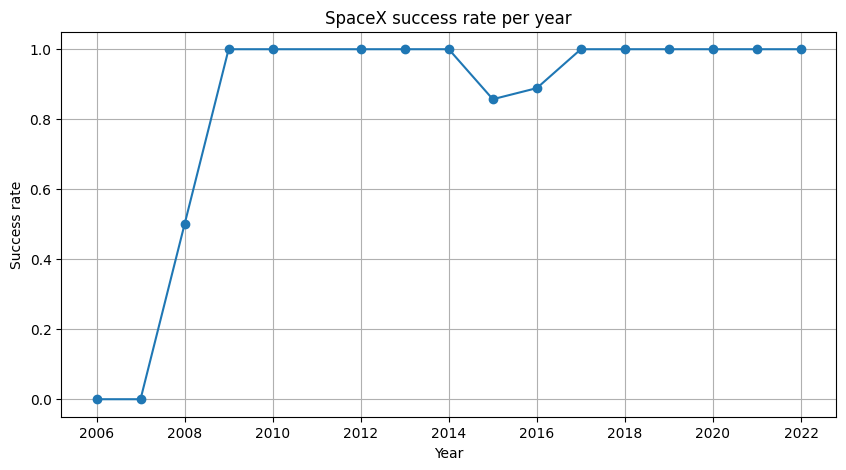

In [8]:
# Success rate per year
succ = df.dropna(subset=['success']).groupby('year')['success'].mean().rename('success_rate').reset_index()
if not succ.empty:
    fig, ax = plt.subplots()
    ax.plot(succ['year'], succ['success_rate'], marker='o')
    ax.set_ylim(-0.05, 1.05)
    ax.set_title('SpaceX success rate per year')
    ax.set_xlabel('Year')
    ax.set_ylabel('Success rate')
    plt.grid(True)
    plt.show()
else:
    print('Not enough success data to plot')


## 6. Save cleaned data
Save a CSV that you can include in your repo for quick demos without repeated API calls.

In [9]:
out_csv = 'spacex_launches_cleaned.csv'
df.to_csv(out_csv, index=False)
print(f"Saved cleaned data to {out_csv}")


Saved cleaned data to spacex_launches_cleaned.csv
